In [10]:
# Libraries
import io
import os
import pandas as pd
import plotly.express as px
import plotly.io as pio

import requests
import math
import matplotlib.pyplot as plt
import shutil
from getpass import getpass
from PIL import Image, UnidentifiedImageError
from requests.exceptions import HTTPError
from io import BytesIO
from pathlib import Path
import torch
import pytorch_lightning as pl

from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTForImageClassification

pio.renderers.default = "png"

In [11]:
# Helper functions

profile_formatter = (
    "s3://cellpainting-gallery/cpg0016-jump/"
    "{Metadata_Source}/workspace/profiles/"
    "{Metadata_Batch}/{Metadata_Plate}/{Metadata_Plate}.parquet"
)

loaddata_formatter = (
    "s3://cellpainting-gallery/cpg0016-jump/"
    "{Metadata_Source}/workspace/load_data_csv/"
    "{Metadata_Batch}/{Metadata_Plate}/load_data_with_illum.parquet"
)

In [12]:
#Load metadata info for entire dataset

if "WORKSPACE_BUCKET" in os.environ:
    # This notebook is running on Terra.
    # Notebook 'workspace_setup.ipynb' cloned the git repo to this directory under $HOME.
    # If you cloned this repository manually to a different directory, edit this value to reflect that location.
    GIT_CLONE_DIR = "~/jump-cellpainting-datasets"
else:
    GIT_CLONE_DIR = "./datasets/"

In [13]:
#METADATA
plates = pd.read_csv(os.path.join(GIT_CLONE_DIR, "metadata/plate.csv.gz"))
wells = pd.read_csv(os.path.join(GIT_CLONE_DIR, "metadata/well.csv.gz"))
compound = pd.read_csv(os.path.join(GIT_CLONE_DIR, "metadata/compound.csv.gz"))
orf = pd.read_csv(os.path.join(GIT_CLONE_DIR, "metadata/orf.csv.gz"))

In [35]:
plates

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType
0,source_1,Batch1_20221004,UL000109,COMPOUND_EMPTY
1,source_1,Batch1_20221004,UL001641,COMPOUND
2,source_1,Batch1_20221004,UL001643,COMPOUND
3,source_1,Batch1_20221004,UL001645,COMPOUND
4,source_1,Batch1_20221004,UL001651,COMPOUND
...,...,...,...,...
2373,source_9,20211103-Run16,GR00004417,COMPOUND
2374,source_9,20211103-Run16,GR00004418,COMPOUND
2375,source_9,20211103-Run16,GR00004419,COMPOUND
2376,source_9,20211103-Run16,GR00004420,COMPOUND


In [14]:
sample = (
    plates.query('Metadata_PlateType=="COMPOUND"')
    .sample(100, random_state=42)
)
sample

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType
786,source_2,20210816_Batch_9,1086292495,COMPOUND
1808,source_6,p211004CPU2OS48hw384exp031JUMP,110000295567,COMPOUND
816,source_2,20210830_Batch_11,1086290521,COMPOUND
2359,source_9,20211102-Run15,GR00004400,COMPOUND
1876,source_6,p211109CPU2OS48hw384exp035JUMP,110000295516,COMPOUND
...,...,...,...,...
2085,source_8,J1,A1170414,COMPOUND
710,source_2,20210726_Batch_7,1086293454,COMPOUND
617,source_2,20210607_Batch_2,1053601817,COMPOUND
840,source_3,CP59,BR5867a3,COMPOUND


In [15]:
# load profiles of all plates
dframes = []
i = 0
u = len(sample)
columns = [
    "Metadata_Source",
    "Metadata_Plate",
    "Metadata_Well",
]
for _, row in sample.iterrows():
    s3_path = profile_formatter.format(**row.to_dict())
    dframes.append(
        pd.read_parquet(s3_path, storage_options={"anon": True}, columns=columns)
    )
    i+=1
    print("profile " + str(i) + " of " + str(u) + " complete")
    
dframes = pd.concat(dframes)

profile 1 of 100 complete
profile 2 of 100 complete
profile 3 of 100 complete
profile 4 of 100 complete
profile 5 of 100 complete
profile 6 of 100 complete
profile 7 of 100 complete
profile 8 of 100 complete
profile 9 of 100 complete
profile 10 of 100 complete
profile 11 of 100 complete
profile 12 of 100 complete
profile 13 of 100 complete
profile 14 of 100 complete
profile 15 of 100 complete
profile 16 of 100 complete
profile 17 of 100 complete
profile 18 of 100 complete
profile 19 of 100 complete
profile 20 of 100 complete
profile 21 of 100 complete
profile 22 of 100 complete
profile 23 of 100 complete
profile 24 of 100 complete
profile 25 of 100 complete
profile 26 of 100 complete
profile 27 of 100 complete
profile 28 of 100 complete
profile 29 of 100 complete
profile 30 of 100 complete
profile 31 of 100 complete
profile 32 of 100 complete
profile 33 of 100 complete
profile 34 of 100 complete
profile 35 of 100 complete
profile 36 of 100 complete
profile 37 of 100 complete
profile 38

In [16]:
dframes

,Metadata_Source,Metadata_Plate,Metadata_Well
0,source_2,1086292495,A01
1,source_2,1086292495,A02
2,source_2,1086292495,A03
3,source_2,1086292495,A04
4,source_2,1086292495,A05
...,...,...,...
379,source_8,A1170408,P20
380,source_8,A1170408,P21
381,source_8,A1170408,P22
382,source_8,A1170408,P23


In [17]:
# merge compounds and wells, then merge all metadata to plates list (dframes)
metadata = compound.merge(wells, on="Metadata_JCP2022")
ann_dframe = metadata.merge(
    dframes, on=["Metadata_Source", "Metadata_Plate", "Metadata_Well"]
)

In [18]:
ann_dframe

,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Source,Metadata_Plate,Metadata_Well
0,JCP2022_000001,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,source_6,110000296383,B15
1,JCP2022_000005,AAAQFGUYHFJNHI-UHFFFAOYSA-N,InChI=1S/C22H22ClN5O2/c1-4-24-20(29)12-18-22-2...,source_6,110000295604,G12
2,JCP2022_000007,AAATVJFGQAZXQO-UHFFFAOYSA-N,InChI=1S/C24H22N2O4S/c1-14-20(15(2)30-26-14)13...,source_2,1053599657,N03
3,JCP2022_000010,AABLKAPUNFMSIA-UHFFFAOYSA-N,InChI=1S/C15H24N4O4S/c1-3-18-14(4-7-16-18)15(2...,source_9,GR00004397,O06
4,JCP2022_000013,AABSTWCOLWSFRA-UHFFFAOYSA-N,InChI=1S/C17H19N5O2S/c1-11-20-14(16-22(11)7-8-...,source_6,110000296383,H03
...,...,...,...,...,...,...
50039,JCP2022_999999,NaN,NaN,source_9,GR00004408,Z42
50040,JCP2022_999999,NaN,NaN,source_9,GR00004408,Z43
50041,JCP2022_999999,NaN,NaN,source_9,GR00004408,Z44
50042,JCP2022_999999,NaN,NaN,source_9,GR00004408,Z45


For image loading:

In [19]:
#gather metadata associated with images
load_data = []
i = 0
u = len(sample)
for _, row in sample.iterrows():
    s3_path = loaddata_formatter.format(**row.to_dict())
    load_data.append(pd.read_parquet(s3_path, storage_options={"anon": True}))
    i+=1
    print("profile " + str(i) + " of " + str(u) + " complete")

load_data = pd.concat(load_data)

profile 1 of 100 complete
profile 2 of 100 complete
profile 3 of 100 complete
profile 4 of 100 complete
profile 5 of 100 complete
profile 6 of 100 complete
profile 7 of 100 complete
profile 8 of 100 complete
profile 9 of 100 complete
profile 10 of 100 complete
profile 11 of 100 complete
profile 12 of 100 complete
profile 13 of 100 complete
profile 14 of 100 complete
profile 15 of 100 complete
profile 16 of 100 complete
profile 17 of 100 complete
profile 18 of 100 complete
profile 19 of 100 complete
profile 20 of 100 complete
profile 21 of 100 complete
profile 22 of 100 complete
profile 23 of 100 complete
profile 24 of 100 complete
profile 25 of 100 complete
profile 26 of 100 complete
profile 27 of 100 complete
profile 28 of 100 complete
profile 29 of 100 complete
profile 30 of 100 complete
profile 31 of 100 complete
profile 32 of 100 complete
profile 33 of 100 complete
profile 34 of 100 complete
profile 35 of 100 complete
profile 36 of 100 complete
profile 37 of 100 complete
profile 38

In [20]:
# link metadata with image filepaths
linked = pd.merge(
    load_data, ann_dframe, on=["Metadata_Source", "Metadata_Plate", "Metadata_Well"]
)
linked[["Metadata_Well", "Metadata_Site"]]

,Metadata_Well,Metadata_Site
0,A01,1
1,A01,2
2,A01,3
3,A01,4
4,A01,5
...,...,...
340420,P24,5
340421,P24,6
340422,P24,7
340423,P24,8


In [36]:
linked

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_Site,FileName_IllumAGP,FileName_IllumDNA,FileName_IllumER,FileName_IllumMito,FileName_IllumRNA,...,PathName_IllumMito,PathName_IllumRNA,PathName_OrigAGP,PathName_OrigDNA,PathName_OrigER,PathName_OrigMito,PathName_OrigRNA,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI
0,source_2,20210816_Batch_9,1086292495,A01,1,1086292495_IllumAGP.npy,1086292495_IllumDNA.npy,1086292495_IllumER.npy,1086292495_IllumMito.npy,1086292495_IllumRNA.npy,...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,JCP2022_085227,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...
1,source_2,20210816_Batch_9,1086292495,A01,2,1086292495_IllumAGP.npy,1086292495_IllumDNA.npy,1086292495_IllumER.npy,1086292495_IllumMito.npy,1086292495_IllumRNA.npy,...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,JCP2022_085227,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...
2,source_2,20210816_Batch_9,1086292495,A01,3,1086292495_IllumAGP.npy,1086292495_IllumDNA.npy,1086292495_IllumER.npy,1086292495_IllumMito.npy,1086292495_IllumRNA.npy,...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,JCP2022_085227,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...
3,source_2,20210816_Batch_9,1086292495,A01,4,1086292495_IllumAGP.npy,1086292495_IllumDNA.npy,1086292495_IllumER.npy,1086292495_IllumMito.npy,1086292495_IllumRNA.npy,...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,JCP2022_085227,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...
4,source_2,20210816_Batch_9,1086292495,A01,5,1086292495_IllumAGP.npy,1086292495_IllumDNA.npy,1086292495_IllumER.npy,1086292495_IllumMito.npy,1086292495_IllumRNA.npy,...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,JCP2022_085227,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340420,source_8,J1,A1170408,P24,5,A1170408_IllumAGP.npy,A1170408_IllumDNA.npy,A1170408_IllumER.npy,A1170408_IllumMito.npy,A1170408_IllumRNA.npy,...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,JCP2022_04605

In [47]:
linked.iloc[110000]

Metadata_Source                                               source_11
Metadata_Batch                                                   Batch3
Metadata_Plate                                                 EC000160
Metadata_Well                                                       N18
Metadata_Site                                                         8
FileName_IllumAGP                                 EC000160_IllumAGP.npy
FileName_IllumDNA                                 EC000160_IllumDNA.npy
FileName_IllumER                                   EC000160_IllumER.npy
FileName_IllumMito                               EC000160_IllumMito.npy
FileName_IllumRNA                                 EC000160_IllumRNA.npy
FileName_OrigAGP                         r14c18f08p01-ch3sk1fk1fl1.tiff
FileName_OrigDNA                         r14c18f08p01-ch1sk1fk1fl1.tiff
FileName_OrigER                          r14c18f08p01-ch2sk1fk1fl1.tiff
FileName_OrigMito                        r14c18f08p01-ch5sk1fk1f

In [48]:
# sample x amount of these with desired targets
target1 = (
    linked.query('Metadata_InChIKey=="SRVFFFJZQVENJC-UHFFFAOYSA-N"')
    .sample(100, random_state=42)
)

target2 = (
    linked.query('Metadata_InChIKey=="KPBNHDGDUADAGP-UHFFFAOYSA-N"')
    .sample(100, random_state=42)
)

target3 = (
    linked.query('Metadata_InChIKey=="KLGWPVNEZUVZPM-UHFFFAOYSA-N"')
    .sample(100, random_state=42)
)

ValueError: Cannot take a larger sample than population when 'replace=False'

image 1 of 100 complete
image 2 of 100 complete
image 3 of 100 complete
image 4 of 100 complete
image 5 of 100 complete
image 6 of 100 complete
image 7 of 100 complete
image 8 of 100 complete
image 9 of 100 complete
image 10 of 100 complete
image 11 of 100 complete
image 12 of 100 complete
image 13 of 100 complete
image 14 of 100 complete
image 15 of 100 complete
image 16 of 100 complete
image 17 of 100 complete
image 18 of 100 complete
image 19 of 100 complete
image 20 of 100 complete
image 21 of 100 complete
image 22 of 100 complete
image 23 of 100 complete
image 24 of 100 complete
image 25 of 100 complete
image 26 of 100 complete
image 27 of 100 complete
image 28 of 100 complete
image 29 of 100 complete
image 30 of 100 complete
image 31 of 100 complete
image 32 of 100 complete
image 33 of 100 complete
image 34 of 100 complete
image 35 of 100 complete
image 36 of 100 complete
image 37 of 100 complete
image 38 of 100 complete
image 39 of 100 complete
image 40 of 100 complete
image 41 

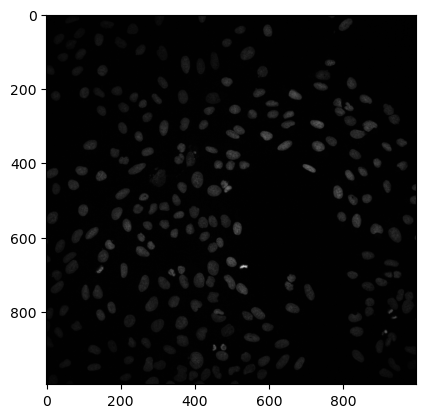

In [21]:
import os
import requests
from io import BytesIO
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import boto3
from botocore import UNSIGNED
from botocore.config import Config
i = 0
u = 100 #len(linked)
test_images = []
test_targets = []
train_images = []
train_targets = []
all_targets = []
for _, row in linked.iterrows():
    image_url = os.path.join(
        row.PathName_OrigDNA, row.FileName_OrigDNA
    )
    s3_client = boto3.client("s3", config=Config(signature_version=UNSIGNED))
    response = s3_client.get_object(
        Bucket=image_url.split("/")[2], Key="/".join(image_url.split("/")[3:])
    )
    image = mpimg.imread(BytesIO(response["Body"].read()), format="tiff")
    target = row.Metadata_InChIKey

    plt.imshow(image, cmap = "gray") # , cmap="gray"
    image_url
    all_targets.append(target)
    if i < 50:
        train_images.append(image)
        train_targets.append(target)
    else:
        test_images.append(image)
        test_targets.append(target)
        
    i+=1
    print("image " + str(i) + " of " + str(u) + " complete")
    if i == u:
        break

In [23]:
label2id = {}
id2label = {}

for i in range(len(all_targets)):
    label2id[all_targets[i]] = str(i)
#     id2label[str(i)] = all_targets[i]

In [30]:
print(len(all_targets))

100


In [28]:
print(label2id)
# print(id2label)

{'SRVFFFJZQVENJC-UHFFFAOYSA-N': '5', 'IAZDPXIOMUYVGZ-UHFFFAOYSA-N': '11', 'BSMCAPRUBJMWDF-UHFFFAOYSA-N': '17', 'CMYCCJYVZIMDFU-UHFFFAOYSA-N': '23', 'OOBJCYKITXPCNS-UHFFFAOYSA-N': '29', 'YMDXSGBNCBQYGC-UHFFFAOYSA-N': '35', 'FYWRWBSYRGSWIQ-UHFFFAOYSA-N': '41', 'IVGJGWNPAKJGGB-UHFFFAOYSA-N': '47', 'KOHMUAMPZUHGNV-UHFFFAOYSA-N': '53', 'UFULAYFCSOUIOV-UHFFFAOYSA-N': '59', 'ZBCMHWUFWQFPLV-UHFFFAOYSA-N': '65', 'ZXOBLNBVNROVLC-UHFFFAOYSA-N': '71', 'RWZVPVOZTJJMNU-UHFFFAOYSA-N': '77', 'SHKXZIQNFMOPBS-UHFFFAOYSA-N': '83', 'NEEVCWPRIZJJRJ-UHFFFAOYSA-N': '89', 'WMRQNQDMFKWESL-UHFFFAOYSA-N': '95', 'LZCOQTDXKCNBEE-UHFFFAOYSA-N': '99'}


In [34]:
print(train_targets)
print(test_targets)

['SRVFFFJZQVENJC-UHFFFAOYSA-N', 'SRVFFFJZQVENJC-UHFFFAOYSA-N', 'SRVFFFJZQVENJC-UHFFFAOYSA-N', 'SRVFFFJZQVENJC-UHFFFAOYSA-N', 'SRVFFFJZQVENJC-UHFFFAOYSA-N', 'SRVFFFJZQVENJC-UHFFFAOYSA-N', 'IAZDPXIOMUYVGZ-UHFFFAOYSA-N', 'IAZDPXIOMUYVGZ-UHFFFAOYSA-N', 'IAZDPXIOMUYVGZ-UHFFFAOYSA-N', 'IAZDPXIOMUYVGZ-UHFFFAOYSA-N', 'IAZDPXIOMUYVGZ-UHFFFAOYSA-N', 'IAZDPXIOMUYVGZ-UHFFFAOYSA-N', 'BSMCAPRUBJMWDF-UHFFFAOYSA-N', 'BSMCAPRUBJMWDF-UHFFFAOYSA-N', 'BSMCAPRUBJMWDF-UHFFFAOYSA-N', 'BSMCAPRUBJMWDF-UHFFFAOYSA-N', 'BSMCAPRUBJMWDF-UHFFFAOYSA-N', 'BSMCAPRUBJMWDF-UHFFFAOYSA-N', 'CMYCCJYVZIMDFU-UHFFFAOYSA-N', 'CMYCCJYVZIMDFU-UHFFFAOYSA-N', 'CMYCCJYVZIMDFU-UHFFFAOYSA-N', 'CMYCCJYVZIMDFU-UHFFFAOYSA-N', 'CMYCCJYVZIMDFU-UHFFFAOYSA-N', 'CMYCCJYVZIMDFU-UHFFFAOYSA-N', 'OOBJCYKITXPCNS-UHFFFAOYSA-N', 'OOBJCYKITXPCNS-UHFFFAOYSA-N', 'OOBJCYKITXPCNS-UHFFFAOYSA-N', 'OOBJCYKITXPCNS-UHFFFAOYSA-N', 'OOBJCYKITXPCNS-UHFFFAOYSA-N', 'OOBJCYKITXPCNS-UHFFFAOYSA-N', 'YMDXSGBNCBQYGC-UHFFFAOYSA-N', 'YMDXSGBNCBQYGC-UHFFFAOYSA-N', 'YMDXSG

MODEL

In [25]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)
collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=8, collate_fn=collator, num_workers=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collator, num_workers=2)

/Users/abestroka/anaconda3/envs/jump/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning:

The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.



ValueError: You passed along `num_labels=17` with an incompatible id to label map: {'0': 'SRVFFFJZQVENJC-UHFFFAOYSA-N', '1': 'SRVFFFJZQVENJC-UHFFFAOYSA-N', '2': 'SRVFFFJZQVENJC-UHFFFAOYSA-N', '3': 'SRVFFFJZQVENJC-UHFFFAOYSA-N', '4': 'SRVFFFJZQVENJC-UHFFFAOYSA-N', '5': 'SRVFFFJZQVENJC-UHFFFAOYSA-N', '6': 'IAZDPXIOMUYVGZ-UHFFFAOYSA-N', '7': 'IAZDPXIOMUYVGZ-UHFFFAOYSA-N', '8': 'IAZDPXIOMUYVGZ-UHFFFAOYSA-N', '9': 'IAZDPXIOMUYVGZ-UHFFFAOYSA-N', '10': 'IAZDPXIOMUYVGZ-UHFFFAOYSA-N', '11': 'IAZDPXIOMUYVGZ-UHFFFAOYSA-N', '12': 'BSMCAPRUBJMWDF-UHFFFAOYSA-N', '13': 'BSMCAPRUBJMWDF-UHFFFAOYSA-N', '14': 'BSMCAPRUBJMWDF-UHFFFAOYSA-N', '15': 'BSMCAPRUBJMWDF-UHFFFAOYSA-N', '16': 'BSMCAPRUBJMWDF-UHFFFAOYSA-N', '17': 'BSMCAPRUBJMWDF-UHFFFAOYSA-N', '18': 'CMYCCJYVZIMDFU-UHFFFAOYSA-N', '19': 'CMYCCJYVZIMDFU-UHFFFAOYSA-N', '20': 'CMYCCJYVZIMDFU-UHFFFAOYSA-N', '21': 'CMYCCJYVZIMDFU-UHFFFAOYSA-N', '22': 'CMYCCJYVZIMDFU-UHFFFAOYSA-N', '23': 'CMYCCJYVZIMDFU-UHFFFAOYSA-N', '24': 'OOBJCYKITXPCNS-UHFFFAOYSA-N', '25': 'OOBJCYKITXPCNS-UHFFFAOYSA-N', '26': 'OOBJCYKITXPCNS-UHFFFAOYSA-N', '27': 'OOBJCYKITXPCNS-UHFFFAOYSA-N', '28': 'OOBJCYKITXPCNS-UHFFFAOYSA-N', '29': 'OOBJCYKITXPCNS-UHFFFAOYSA-N', '30': 'YMDXSGBNCBQYGC-UHFFFAOYSA-N', '31': 'YMDXSGBNCBQYGC-UHFFFAOYSA-N', '32': 'YMDXSGBNCBQYGC-UHFFFAOYSA-N', '33': 'YMDXSGBNCBQYGC-UHFFFAOYSA-N', '34': 'YMDXSGBNCBQYGC-UHFFFAOYSA-N', '35': 'YMDXSGBNCBQYGC-UHFFFAOYSA-N', '36': 'FYWRWBSYRGSWIQ-UHFFFAOYSA-N', '37': 'FYWRWBSYRGSWIQ-UHFFFAOYSA-N', '38': 'FYWRWBSYRGSWIQ-UHFFFAOYSA-N', '39': 'FYWRWBSYRGSWIQ-UHFFFAOYSA-N', '40': 'FYWRWBSYRGSWIQ-UHFFFAOYSA-N', '41': 'FYWRWBSYRGSWIQ-UHFFFAOYSA-N', '42': 'IVGJGWNPAKJGGB-UHFFFAOYSA-N', '43': 'IVGJGWNPAKJGGB-UHFFFAOYSA-N', '44': 'IVGJGWNPAKJGGB-UHFFFAOYSA-N', '45': 'IVGJGWNPAKJGGB-UHFFFAOYSA-N', '46': 'IVGJGWNPAKJGGB-UHFFFAOYSA-N', '47': 'IVGJGWNPAKJGGB-UHFFFAOYSA-N', '48': 'KOHMUAMPZUHGNV-UHFFFAOYSA-N', '49': 'KOHMUAMPZUHGNV-UHFFFAOYSA-N', '50': 'KOHMUAMPZUHGNV-UHFFFAOYSA-N', '51': 'KOHMUAMPZUHGNV-UHFFFAOYSA-N', '52': 'KOHMUAMPZUHGNV-UHFFFAOYSA-N', '53': 'KOHMUAMPZUHGNV-UHFFFAOYSA-N', '54': 'UFULAYFCSOUIOV-UHFFFAOYSA-N', '55': 'UFULAYFCSOUIOV-UHFFFAOYSA-N', '56': 'UFULAYFCSOUIOV-UHFFFAOYSA-N', '57': 'UFULAYFCSOUIOV-UHFFFAOYSA-N', '58': 'UFULAYFCSOUIOV-UHFFFAOYSA-N', '59': 'UFULAYFCSOUIOV-UHFFFAOYSA-N', '60': 'ZBCMHWUFWQFPLV-UHFFFAOYSA-N', '61': 'ZBCMHWUFWQFPLV-UHFFFAOYSA-N', '62': 'ZBCMHWUFWQFPLV-UHFFFAOYSA-N', '63': 'ZBCMHWUFWQFPLV-UHFFFAOYSA-N', '64': 'ZBCMHWUFWQFPLV-UHFFFAOYSA-N', '65': 'ZBCMHWUFWQFPLV-UHFFFAOYSA-N', '66': 'ZXOBLNBVNROVLC-UHFFFAOYSA-N', '67': 'ZXOBLNBVNROVLC-UHFFFAOYSA-N', '68': 'ZXOBLNBVNROVLC-UHFFFAOYSA-N', '69': 'ZXOBLNBVNROVLC-UHFFFAOYSA-N', '70': 'ZXOBLNBVNROVLC-UHFFFAOYSA-N', '71': 'ZXOBLNBVNROVLC-UHFFFAOYSA-N', '72': 'RWZVPVOZTJJMNU-UHFFFAOYSA-N', '73': 'RWZVPVOZTJJMNU-UHFFFAOYSA-N', '74': 'RWZVPVOZTJJMNU-UHFFFAOYSA-N', '75': 'RWZVPVOZTJJMNU-UHFFFAOYSA-N', '76': 'RWZVPVOZTJJMNU-UHFFFAOYSA-N', '77': 'RWZVPVOZTJJMNU-UHFFFAOYSA-N', '78': 'SHKXZIQNFMOPBS-UHFFFAOYSA-N', '79': 'SHKXZIQNFMOPBS-UHFFFAOYSA-N', '80': 'SHKXZIQNFMOPBS-UHFFFAOYSA-N', '81': 'SHKXZIQNFMOPBS-UHFFFAOYSA-N', '82': 'SHKXZIQNFMOPBS-UHFFFAOYSA-N', '83': 'SHKXZIQNFMOPBS-UHFFFAOYSA-N', '84': 'NEEVCWPRIZJJRJ-UHFFFAOYSA-N', '85': 'NEEVCWPRIZJJRJ-UHFFFAOYSA-N', '86': 'NEEVCWPRIZJJRJ-UHFFFAOYSA-N', '87': 'NEEVCWPRIZJJRJ-UHFFFAOYSA-N', '88': 'NEEVCWPRIZJJRJ-UHFFFAOYSA-N', '89': 'NEEVCWPRIZJJRJ-UHFFFAOYSA-N', '90': 'WMRQNQDMFKWESL-UHFFFAOYSA-N', '91': 'WMRQNQDMFKWESL-UHFFFAOYSA-N', '92': 'WMRQNQDMFKWESL-UHFFFAOYSA-N', '93': 'WMRQNQDMFKWESL-UHFFFAOYSA-N', '94': 'WMRQNQDMFKWESL-UHFFFAOYSA-N', '95': 'WMRQNQDMFKWESL-UHFFFAOYSA-N', '96': 'LZCOQTDXKCNBEE-UHFFFAOYSA-N', '97': 'LZCOQTDXKCNBEE-UHFFFAOYSA-N', '98': 'LZCOQTDXKCNBEE-UHFFFAOYSA-N', '99': 'LZCOQTDXKCNBEE-UHFFFAOYSA-N'}. Since those arguments are inconsistent with each other, you should remove one of them.

TRAINING

In [ ]:
class Classifier(pl.LightningModule):

    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.val_acc = Accuracy(
            task='multiclass' if model.config.num_labels > 2 else 'binary',
            num_classes=model.config.num_labels
        )

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"train_loss", outputs.loss)
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"val_loss", outputs.loss)
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        self.log(f"val_acc", acc, prog_bar=True)
        return outputs.loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [ ]:
pl.seed_everything(42)
classifier = Classifier(model, lr=2e-5)
trainer = pl.Trainer(accelerator='gpu', devices=1, precision=16, max_epochs=4)
trainer.fit(classifier, train_loader, val_loader)